In [1]:
%%capture
!pip install transformers
!pip install accelerate
!pip install git+https://github.com/huggingface/accelerate
!pip install ml_collections
!pip install datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ml_collections
import datasets
import torch
import transformers
from accelerate import Accelerator, DistributedType
from datasets import load_metric, Dataset, DatasetDict
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
)
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from wordcloud import WordCloud, STOPWORDS
import re,string, nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer

import warnings
warnings.filterwarnings(action="ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Check for duplicated review.


In [4]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Dataset/IMDB Dataset.csv')


In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.shape

(50000, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
 #Remove Duplicate reviews
 df_duplicate = df[df['review'].duplicated()]
 print("No of duplicate review: ",len(df_duplicate))
 df.drop_duplicates(subset=['review'],keep='first',inplace=True)

No of duplicate review:  418


**Check missing value**

In [7]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

**Check dataset is balanced or not**

In [8]:
df['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

In [9]:
labelencoder = LabelEncoder()
df["label_enc"] = labelencoder.fit_transform(df["sentiment"])
df=df.drop('sentiment',axis=1)
df=df.rename(columns={'label_enc':'sentiment'})

In [10]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [11]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm','im', 'll', 'y', 've',
                      'u', 'ur', 'don','p', 't', 's', 'aren', 'kp', 'o', 'kat',
                      'de', 're', 'amp', 'will'])

def remove_stopwords(text):
  text = " ".join([stemmer.stem(word) for word in str(text).split()])
  text = [lemmatizer.lemmatize(word) for word in str(text).split() if not word in set(STOPWORDS)]
  text = ' '.join(text)
  return text

df['review']=df['review'].astype(str).apply(remove_stopwords)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [12]:
def preprocess(df,field):
    df[field] = df[field].str.replace(r"http\S+"," ")
    df[field] = df[field].str.replace(r"http"," ")
    df[field] = df[field].str.replace(r"@","at")
    df[field] = df[field].str.replace("#[A-Za-z0-9_]+", ' ')
    df[field] = df[field].str.replace(r"[^A-Za-z(),!?@\'\"_\n]"," ")
    df[field] = df[field].str.lower()
    return df
df = preprocess(df,'review')
df

,review,sentiment
0,one review mention watch oz episod hooked r...,1
1,wonder littl production br br the film ...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy (jake) think zombi clos...,0
4,"petter mattei ""love time money"" visual stun fi...",1
...,...,...
49995,thought movi right good job creativ origin fi...,1
49996,"bad plot, bad dialogue, bad acting, idiot dire...",0
49997,"cathol taught parochi elementari school nuns, ...",0
49998,go disagre previous comment side maltin one s...,0


In [13]:
def preprocess_text(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would",text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = re.sub(r'[^\x00-\x7f]','',text)
    text = " ".join([stemmer.stem(word) for word in text.split()])
    text = [lemmatizer.lemmatize(word) for word in text.split() if not word in set(STOPWORDS)]
    text = ' '.join(text)
    return text
df['review']=df['review'].astype(str).apply(preprocess_text)

In [14]:
df

,review,sentiment
0,one review mention watch oz episod hook right ...,1
1,wonder littl product br br film techniqu veri ...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1
...,...,...
49995,thought movi right good job creativ origin fir...,1
49996,bad plot bad dialogu bad act idiot direct anno...,0
49997,cathol taught parochi elementari school nun ta...,0
49998,go disagr previous comment side maltin one sec...,0


In [ ]:
# #Save preprocessed dataframe to a csv
# df.to_csv('/content/drive/MyDrive/Dataset/preprocessed_df.csv', index=False)

In [ ]:
# #Read preprocessed Dataframe again
# import pandas as pd
# df=pd.read_csv('/content/drive/MyDrive/Dataset/preprocessed_df.csv')



In [15]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df["review"]),np.array(df["sentiment"]), test_size=0.25, random_state=42)

In [16]:
tfidf = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize,min_df=0.00002,max_df=0.70)
X_train_tf = tfidf.fit_transform(X_train.astype('U'))
X_test_tf = tfidf.transform(X_test.astype('U'))

print(f"TF_IDF Model: Train features shape:{X_train_tf.shape} and Test features shape:{X_test_tf.shape}")

TF_IDF Model: Train features shape:(37186, 60454) and Test features shape:(12396, 60454)


In [17]:
def fit_model(algo,x_train,y_train,x_test, y_test):
    algo.fit(x_train,y_train)
    y_pred = algo.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy

In [ ]:
accuracys = {}

In [18]:
rf = RandomForestClassifier(random_state=42)
curr_acc = fit_model(rf,X_train_tf,y_train,X_test_tf,y_test)
print("curr_acc: ",curr_acc)


curr_acc:  0.8494675701839303


In [ ]:
gb = GradientBoostingClassifier(random_state=42)
curr_acc = fit_model(gb,X_train_tf,y_train,X_test_tf,y_test)
print("curr_acc: ",curr_acc)

curr_acc:  0.8062278154243304


In [ ]:
dt = DecisionTreeClassifier(random_state=42)
curr_acc = fit_model(dt,X_train_tf,y_train,X_test_tf,y_test)
print("curr_acc: ",curr_acc)
accuracys.append(curr_acc)

curr_acc:  0.7122458857696031


In [ ]:
svc = SVC(random_state=42)
curr_acc = fit_model(svc,X_train_tf,y_train,X_test_tf,y_test)
print("curr_acc: ",curr_acc)
accuracys.append(curr_acc)

curr_acc:  0.8918199419167473


In [ ]:
nb = MultinomialNB()
curr_acc = fit_model(nb,X_train_tf,y_train,X_test_tf,y_test)
print("curr_acc: ",curr_acc)
accuracys.append(curr_acc)

curr_acc:  0.8582607292675056


In [ ]:
mlp = MLPClassifier(random_state=42)
curr_acc = fit_model(mlp,X_train_tf,y_train,X_test_tf,y_test)
print("curr_acc: ",curr_acc)
accuracys.append(curr_acc)

curr_acc:  0.861568247821878


In [ ]:
models_df = pd.DataFrame({"Models":algos.keys(),"Accuracy Scores":accuracys}).sort_values('Accuracy Scores',ascending=False)
models_df

In [ ]:
# #Read preprocessed Dataframe again
# import pandas as pd
# df=pd.read_csv('/content/drive/MyDrive/Dataset/preprocessed_df.csv')

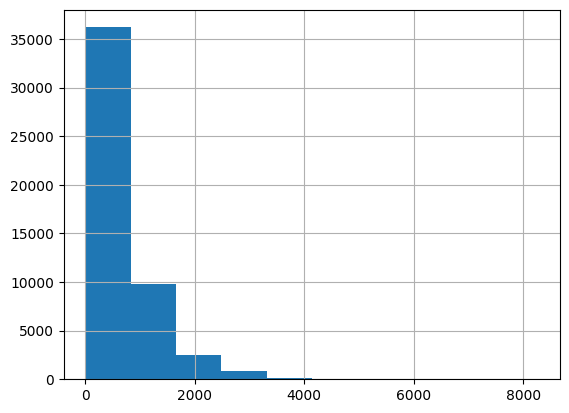

count    49582.000000
mean       723.830281
std        559.582194
min         17.000000
25%        377.000000
50%        531.000000
75%        881.000000
max       8254.000000
dtype: float64

In [ ]:
#Review length analysis
import seaborn as sns
import matplotlib.pyplot as plt
rev_len = [len(i) for i in df['review']]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [ ]:
model_path = "bert_model.h5"
model_type = "transformer"
test_size= 0.20
validation_size=0.20
train_batch_size= 32
eval_batch_size= 32
epochs= 10
adam_epsilon= 1e-8
lr= 3e-5
num_warmup_steps= 10
max_length= 120
random_seed= 42
num_labels= 2
model_checkpoint="roberta-base"

In [ ]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [ ]:
df.rename(columns={"sentiment": "labels"}, inplace=True)

In [ ]:
# df = df[:400].copy()

In [ ]:
def create_dataset(dataframe):
    training_df, test_df = train_test_split(
        dataframe,
        test_size= test_size,
        random_state= random_seed,
        stratify=dataframe.labels.values,
    )
    train_df, val_df = train_test_split(
        training_df,
        test_size= validation_size,
        random_state= random_seed,
        stratify=training_df.labels.values,
    )

    dataset = {
        "train": Dataset.from_pandas(train_df),
        "validation": Dataset.from_pandas(val_df),
        "test": Dataset.from_pandas(test_df),
    }

    dataset = DatasetDict(dataset)

    return dataset

In [ ]:
def tokenize_dataset():
    dataset = create_dataset(df)
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,use_fast=True)

    def tokenize_function(sample):
        outputs = tokenizer(
            sample["review"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
        )
        return outputs

    tokenized_datasets = dataset.map(
        tokenize_function, batched=True, remove_columns=["review","__index_level_0__"]
    )
    tokenized_datasets.set_format("torch")

    return tokenized_datasets, tokenizer

In [ ]:
def create_dataloaders():
    tokenized_datasets, tokenizer = tokenize_dataset()
    train_dataloader = DataLoader(
        tokenized_datasets["train"], shuffle=True, batch_size=train_batch_size
    )
    eval_dataloader = DataLoader(
        tokenized_datasets["validation"], shuffle=False, batch_size=eval_batch_size
    )
    return train_dataloader, eval_dataloader , tokenizer

Map:   0%|          | 0/31732 [00:00<?, ? examples/s]

Map:   0%|          | 0/7933 [00:00<?, ? examples/s]

Map:   0%|          | 0/9917 [00:00<?, ? examples/s]

Map:   0%|          | 0/31732 [00:00<?, ? examples/s]

Map:   0%|          | 0/7933 [00:00<?, ? examples/s]

Map:   0%|          | 0/9917 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/9920 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.2987 - Train Accuracy: 0.8713
Epoch 1 - Validation Loss: 0.2418 - Validation Accuracy: 0.8988
Epoch 2 - Train Loss: 0.1956 - Train Accuracy: 0.9225
Epoch 2 - Validation Loss: 0.2243 - Validation Accuracy: 0.9071
Epoch 3 - Train Loss: 0.1283 - Train Accuracy: 0.9532
Epoch 3 - Validation Loss: 0.2813 - Validation Accuracy: 0.8994
Epoch 4 - Train Loss: 0.0795 - Train Accuracy: 0.9710
Epoch 4 - Validation Loss: 0.2987 - Validation Accuracy: 0.9065
Epoch 5 - Train Loss: 0.0496 - Train Accuracy: 0.9834
Epoch 5 - Validation Loss: 0.3617 - Validation Accuracy: 0.9072
Epoch 6 - Train Loss: 0.0300 - Train Accuracy: 0.9905
Epoch 6 - Validation Loss: 0.4484 - Validation Accuracy: 0.9073
Epoch 7 - Train Loss: 0.0198 - Train Accuracy: 0.9938
Epoch 7 - Validation Loss: 0.4368 - Validation Accuracy: 0.9113
Epoch 8 - Train Loss: 0.0136 - Train Accuracy: 0.9961
Epoch 8 - Validation Loss: 0.4695 - Validation Accuracy: 0.9086
Epoch 9 - Train Loss: 0.0078 - Train Accuracy: 0.9978
Ep

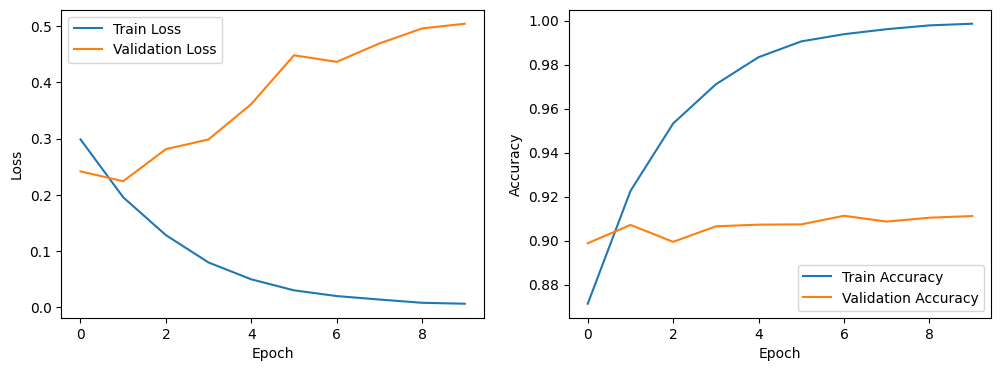

In [ ]:

import matplotlib.pyplot as plt
best_val_accuracy = 0.0
best_model_checkpoint = None

def training_function():
    global best_val_accuracy, best_model_checkpoint
    accelerator = Accelerator(gradient_accumulation_steps=2)
    set_seed(42)

    # Tokenize your datasets and load the accuracy metric here
    tokenized_datasets = tokenize_dataset()
    accuracy = load_metric("accuracy")

    # Create dataloaders
    train_dataloader, eval_dataloader, tokenizer = create_dataloaders()

    # Load or initialize your model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_checkpoint, num_labels=num_labels
    )

    # Move model and dataloaders to GPU if available
    model, train_dataloader, eval_dataloader = accelerator.prepare(
        model, train_dataloader, eval_dataloader
    )

    # Define optimizer and learning rate scheduler
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=len(train_dataloader) * epochs,
    )
    progress_bar = tqdm(
        range(epochs * len(train_dataloader)),
        disable=not accelerator.is_main_process,
    )

    # Lists to store training metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Model Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for step, batch in enumerate(train_dataloader):
            inputs = {
                "input_ids": batch["input_ids"],
                "attention_mask": batch["attention_mask"],
                "labels": batch["labels"],
            }
            outputs = model(**inputs)
            loss = outputs.loss
            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)


            # Compute training accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += torch.sum(predictions == inputs["labels"]).item()
            total_samples += len(inputs["labels"])

            total_loss += loss.item()

        # Compute training accuracy and loss
        train_loss = total_loss / len(train_dataloader)
        train_accuracy = correct_predictions / total_samples

        # Evaluate on validation data
        model.eval()
        val_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in eval_dataloader:
            with torch.no_grad():
                inputs = {
                    "input_ids": batch["input_ids"],
                    "attention_mask": batch["attention_mask"],
                    "labels": batch["labels"],
                }
                outputs = model(**inputs)
                loss = outputs.loss

                # Compute validation accuracy
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=-1)
                correct_predictions += torch.sum(predictions == inputs["labels"]).item()
                total_samples += len(inputs["labels"])

                val_loss += loss.item()

        # Compute validation accuracy and loss
        val_loss /= len(eval_dataloader)
        val_accuracy = correct_predictions / total_samples

        # Append metrics to lists for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print and plot progress
        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
        print(f"Epoch {epoch + 1} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")

        # Check if validation accuracy has improved
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # Save the best model checkpoint
            best_model_checkpoint = f"best_model_checkpoint"
            model.save_pretrained(best_model_checkpoint)
            tokenizer.save_pretrained("tokenizer")

    # Plot loss and accuracy curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Call your training function
training_function()


In [ ]:
#Inference

tokenizer = AutoTokenizer.from_pretrained("/content/tokenizer")
model = AutoModelForSequenceClassification.from_pretrained("/content/best_model_checkpoint")

example_text = "This is a master piece from SRK."

# Tokenize and preprocess the input
inputs = tokenizer(example_text, return_tensors="pt", padding=True, truncation=True)

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
predicted_probabilities = torch.softmax(logits, dim=1)
predicted_labels = torch.argmax(predicted_probabilities, dim=1).item()

# Display the results
print("Predicted class probabilities:", predicted_probabilities)
print("Predicted label:", predicted_labels)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Predicted class probabilities: tensor([[8.8720e-04, 9.9911e-01]])
Predicted label: 1
